# Plot Paloma data

## Imports and setup

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd

import wandb

rc_fonts = {
    "text.usetex": True,
    "text.latex.preamble": "\n".join(
        [r"\usepackage{libertine}", r"\usepackage[libertine]{newtxmath}", r"\usepackage{inconsolata}"]
    ),
}
mpl.rcParams.update(rc_fonts)


def format_ticks(x, pos):
    if x >= 10000:
        return f"{int(x):,}"
    return str(int(x))


wandb.login()

True

In [15]:
TICK_LABEL_SIZE = 26
AXIS_LABEL_SIZE = 30

## Get data from runs

In [64]:
api = wandb.Api()

RUN_SCALE = "tiny"

if RUN_SCALE == "tiny":
    baseline_run = api.run("pico-lm/pico-decoder/lne20rc1")  # pico decoder tiny
    relora_run = api.run("pico-lm/pico-relora/6vhmv4aj")  # pico relora tiny
else:
    baseline_run = api.run("pico-lm/pico-decoder/kzcalg17")
    relora_run = api.run("pico-lm/pico-relora/5urfvs2j")


baseline_df = pd.DataFrame(baseline_run.scan_history())
relora_df = pd.DataFrame(relora_run.scan_history())

In [65]:
def get_data_from_df(
    df: pd.DataFrame, metric: str, n_gpus: int, interval: pd.Timedelta, end_offset: pd.Timedelta
):
    df = df.copy()
    df = df[df[metric].notna()]

    df["_runtime"] = pd.to_timedelta(df["_runtime"], unit="s")
    df["_runtime"] = df["_runtime"] - df["_runtime"].iloc[0]
    df["gpu_time"] = df["_runtime"] * n_gpus

    df = df.sort_values("gpu_time")

    target_offsets = pd.timedelta_range(start="0min", end=end_offset, freq=interval)
    df = pd.merge_asof(pd.DataFrame({"gpu_time": target_offsets}), df, on="gpu_time", direction="nearest")

    df.loc[df.index[-1], "trainer/global_step"] += 1
    df.drop_duplicates(subset=["trainer/global_step"], inplace=True)

    return df["gpu_time"].dt.total_seconds().to_numpy() / 3600, df[metric].to_numpy()

In [66]:
MAX_TIME = pd.Timedelta("818h")
MAX_TIME_HRS = MAX_TIME.total_seconds() / 3600
INTERVAL = pd.Timedelta("20h")

41


/var/folders/2y/6ry1xqnj2r9_fpqf_pp017mw0000gn/T/ipykernel_99982/1620389549.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


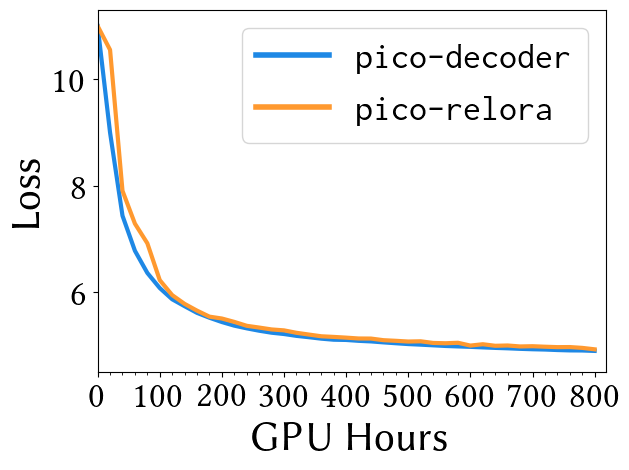

In [67]:
baseline_data_loss = get_data_from_df(baseline_df, "train/loss", 16, INTERVAL, MAX_TIME)
relora_data_loss = get_data_from_df(relora_df, "train/loss", 4, INTERVAL, MAX_TIME)

print(len(baseline_data_loss[0]))

fig, ax = plt.subplots()

colors = ["#1E88E5", "#FF992F"]

# ax.scatter(*baseline_data_loss, color=colors[0], marker="s", s=20)
LINE_WIDTH = 3
ax.plot(*baseline_data_loss, color=colors[0], label=r"\texttt{pico-decoder}", linewidth=LINE_WIDTH)

# ax.scatter(*relora_data_loss, color=colors[1], marker="o", s=20)
ax.plot(*relora_data_loss, color=colors[1], label=r"\texttt{pico-relora}", linewidth=LINE_WIDTH)

ax.set_xlabel("GPU Hours", fontdict={"size": AXIS_LABEL_SIZE})
ax.set_ylabel("Loss", fontdict={"size": AXIS_LABEL_SIZE})

ax.set_xlim(0, MAX_TIME_HRS)

ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(20))
ax.set_axisbelow(True)
# ax.grid(which="both", axis="both", color="#E5E5E5")

ax.set_ylim(3.5 if RUN_SCALE == "small" else 4.5, 11.3)


ax.tick_params(axis="both", labelsize=TICK_LABEL_SIZE)

# legend_elements = [
#     Line2D(
#         [0], [0], color=colors[0], marker="s", linestyle="-", label=r"\texttt{pico-decoder}", markersize=5
#     ),
#     Line2D(
#         [0], [0], color=colors[1], marker="o", linestyle="-", label=r"\texttt{pico-relora}", markersize=5
#     ),
# ]

leg = ax.legend(fontsize=TICK_LABEL_SIZE)
for line in leg.get_lines():
    line.set_linewidth(4)

fig.tight_layout()
fig.savefig(f"../graphs/{RUN_SCALE}_loss_gpu_hrs.pdf")
fig.show()

/var/folders/2y/6ry1xqnj2r9_fpqf_pp017mw0000gn/T/ipykernel_99982/4173775966.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


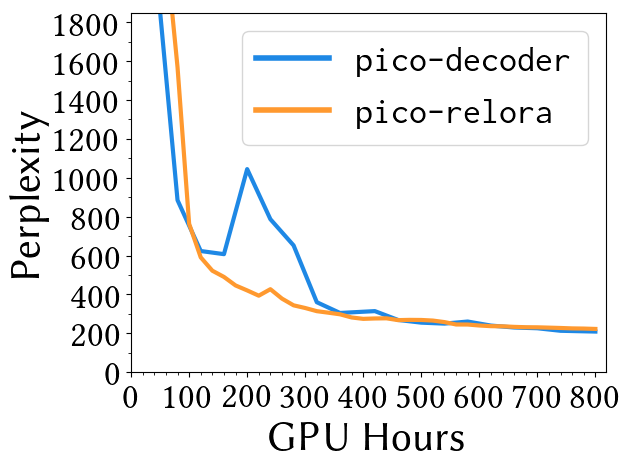

In [68]:
baseline_data_paloma = get_data_from_df(baseline_df, "eval/paloma", 16, INTERVAL, MAX_TIME)
relora_data_paloma = get_data_from_df(relora_df, "eval/paloma", 4, INTERVAL, MAX_TIME)

fig, ax = plt.subplots()

colors = ["#1E88E5", "#FF992F"]

# ax.scatter(*baseline_data_paloma, color=colors[0], marker="s", s=20)
ax.plot(*baseline_data_paloma, color=colors[0], label=r"\texttt{pico-decoder}", linewidth=LINE_WIDTH)

# ax.scatter(*relora_data_paloma, color=colors[1], marker="o", s=20)
ax.plot(*relora_data_paloma, color=colors[1], label=r"\texttt{pico-relora}", linewidth=LINE_WIDTH)

ax.set_xlabel("GPU Hours", fontdict={"size": AXIS_LABEL_SIZE})
ax.set_ylabel("Perplexity", fontdict={"size": AXIS_LABEL_SIZE})

ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(20))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(100))

ax.set_axisbelow(True)
# ax.grid(which="both", axis="both", color="#E5E5E5")

y_ticks = np.arange(0, 1801, 200)
ax.set_yticks(y_ticks, minor=False)
ax.set_xlim(0, MAX_TIME_HRS)
ax.set_ylim(0, 1850)

ax.tick_params(axis="both", labelsize=TICK_LABEL_SIZE)

# legend_elements = [
#     Line2D(
#         [0], [0], color=colors[0], marker="s", linestyle="-", label=r"\texttt{pico-decoder}", markersize=5
#     ),
#     Line2D(
#         [0], [0], color=colors[1], marker="o", linestyle="-", label=r"\texttt{pico-relora}", markersize=5
#     ),
# ]

leg = ax.legend(fontsize=TICK_LABEL_SIZE)
for line in leg.get_lines():
    line.set_linewidth(4)


fig.tight_layout()
fig.savefig(f"../graphs/{RUN_SCALE}_ppl_gpu_hrs.pdf")
fig.show()